<a href="https://colab.research.google.com/github/Kareemothman/Kareem/blob/master/0000_STA_A_3(FINAL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Name: Kareem Othman
# Student Number: 1006586160
# Assignment (3)
# Developed by Google Colab



# Load Data and Packages

In [0]:
import numpy as np
import os
import gzip
import struct
import array

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import matplotlib.image
from urllib.request import urlretrieve

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images, test_labels


def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

In [0]:
N_data, train_images, train_labels, test_images, test_labels = load_mnist()
train_images = torch.from_numpy(np.round(train_images[0:10000])).float()
train_labels = torch.from_numpy(train_labels[0:10000]).float()
test_images = torch.from_numpy(np.round(test_images[0:10000])).float()
test_labels = torch.from_numpy(test_labels[0:10000])

batch_size = 100
num_batches = int(np.ceil(len(train_images) / batch_size))
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)


# Probability Stuff

In [0]:
# sampler from Diagonal Gaussian x~N(μ,σI)
def sample_diagonal_gaussian(mu, sigma_square):
  return mu + torch.sqrt(sigma_square)*torch.randn(sigma_square.shape)

# sampler from Bernoulli
def sample_Bernoulli(y):
  x = torch.rand(y.shape)
  x = (x<y).float()
  return x
  
# log-pdf of x under Diagonal Gaussian N(x|μ,σI)
def logpdf_diagonal_gaussian(x, mu, sigma_square):
  log_det_sigma = torch.sum(torch.log(sigma_square),-1) 
  x_mu_diff = x-mu 
  sigma_inverse = 1/sigma_square
  k = x.shape[-1]
  s = x_mu_diff.shape[-1]
  logprob = -0.5*(log_det_sigma + torch.bmm(x_mu_diff.view(-1,1,s), (sigma_inverse * x_mu_diff).view(-1,s,1)).view(-1) + k * np.log(np.pi*2))
  return logprob

# log-pdf of x under Bernoulli 
def logpdf_bernoulli(x, y):
  return torch.sum(x*torch.log(y) + (1-x)*torch.log(1-y), -1)

# Question (1) - Implementing the Model

## Question (1)-a - Log_prior

In [0]:
# log_prior_function
def log_p_z(z):
    return logpdf_diagonal_gaussian(z, torch.zeros(z.shape), torch.ones(z.shape))

## Question (1)-b - Encoder and Decoder

In [0]:
latent_dimension = 2
hidden_units = 500

# Define encoder
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    
    self.fc1 = nn.Linear(784, hidden_units)
    self.fc2_mu = nn.Linear(hidden_units, latent_dimension)
    self.fc2_sigma = nn.Linear(hidden_units, latent_dimension)
    
  def forward(self, x):
    hidden = torch.tanh(self.fc1(x))
    mu = self.fc2_mu(hidden)
    log_sigma_square = self.fc2_sigma(hidden)
    sigma_square = torch.exp(log_sigma_square)
    return mu, sigma_square

# Samples z ~ q(z|x)
def sample_z(mu, sigma_square):
  zs = sample_diagonal_gaussian(mu, sigma_square)
  return zs

# Define decoder
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    
    self.fc1 = nn.Linear(latent_dimension, hidden_units)
    self.fc2 = nn.Linear(hidden_units, 784)
    
  def forward(self, z):
    hidden = torch.tanh(self.fc1(z))
    y = torch.sigmoid(self.fc2(hidden))
    return y

## Question (1)-c - log likelihood

In [0]:
# log_p(x|z) - conditional probability of data given latents.
def log_p_xgivenz(x, theta):
    return logpdf_bernoulli(x, theta)

## Quetison (1) - d- joint log density

In [0]:
def joint_log_density(x,y):
  return log_p_xgivenz(x, y) + log_p_z(y)

# Question (2) - Amortized Approximate Inference and training

## Quetison (2) - a-Encoder Similar to the one above as i defined both encoder ad decoder together above

In [0]:
latent_dimension = 2
hidden_units = 500

# Define encoder
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    
    self.fc1 = nn.Linear(784, hidden_units)
    self.fc2_mu = nn.Linear(hidden_units, latent_dimension)
    self.fc2_sigma = nn.Linear(hidden_units, latent_dimension)
    
  def forward(self, x):
    hidden = torch.tanh(self.fc1(x))
    mu = self.fc2_mu(hidden)
    log_sigma_square = self.fc2_sigma(hidden)
    sigma_square = torch.exp(log_sigma_square)
    return mu, sigma_square

## Quetison (2) - b-log q

In [0]:
def log_q(x,y,z):
    return logpdf_diagonal_gaussian(x,y,z)

## Quetison (2) - c- ELBO

In [0]:
def mc_elbo(sampled_z, mu, sigma_square, x, y):
  # log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
  log_q = logpdf_diagonal_gaussian(sampled_z, mu, sigma_square)

  # log_p_z(z) log probability of z under prior
  z_mu = torch.FloatTensor([0]*latent_dimension)
  z_sigma = torch.FloatTensor([1]*latent_dimension)
  log_p_z = logpdf_diagonal_gaussian(sampled_z, z_mu, z_sigma)

  # log_p(x|z) - conditional probability of data given latents.
  log_p = logpdf_bernoulli(x, y)

  elbo = torch.mean(-log_q + log_p_z + log_p)
  return elbo

## Quetison (2) - d- Loss

In [0]:
def loss(sampled_z, mu, sigma_square, x, y):
  return -elbo(sampled_z, mu, sigma_square, x, y)

## Quetison (2) - e- Trainning

### Function

In [13]:
r_seed = 1
np.random.seed(r_seed)
torch.random.manual_seed(r_seed) 

def train_model():
  # ADAM 
  encoder = Encoder()
  decoder = Decoder()
  params = list(encoder.parameters()) + list(decoder.parameters())
  adam_optimizer = optim.Adam(params)
  num_epoches = 100
  num_iters = num_epoches * num_batches
  for i in range(num_iters):
    x_minibatch = train_images[batch_indices(i),:]
    adam_optimizer.zero_grad()
    mu, sigma_square = encoder(x_minibatch)
    zs = sample_z(mu, sigma_square)
    y = decoder(zs)
    elbo = mc_elbo(zs, mu, sigma_square, x_minibatch, y)
    total_loss = -elbo
    total_loss.backward()
    adam_optimizer.step()
    if i%100 == 0:
      print("Test loss at epoch: " + str(i//num_batches) + ", Negative_ELBO(Loss):" + str(-elbo.item()))

train_model()

Test loss at epoch: 0, Negative_ELBO(Loss):554.6314697265625
Test loss at epoch: 1, Negative_ELBO(Loss):182.71771240234375
Test loss at epoch: 2, Negative_ELBO(Loss):178.5731964111328
Test loss at epoch: 3, Negative_ELBO(Loss):176.1427764892578
Test loss at epoch: 4, Negative_ELBO(Loss):174.5128173828125
Test loss at epoch: 5, Negative_ELBO(Loss):172.36070251464844
Test loss at epoch: 6, Negative_ELBO(Loss):170.89761352539062
Test loss at epoch: 7, Negative_ELBO(Loss):169.24595642089844
Test loss at epoch: 8, Negative_ELBO(Loss):167.54019165039062
Test loss at epoch: 9, Negative_ELBO(Loss):166.11630249023438
Test loss at epoch: 10, Negative_ELBO(Loss):164.6890411376953
Test loss at epoch: 11, Negative_ELBO(Loss):164.32107543945312
Test loss at epoch: 12, Negative_ELBO(Loss):161.51414489746094
Test loss at epoch: 13, Negative_ELBO(Loss):160.6885528564453
Test loss at epoch: 14, Negative_ELBO(Loss):159.16102600097656
Test loss at epoch: 15, Negative_ELBO(Loss):158.4860382080078
Test loss

### For Loop

In [15]:
r_seed = 1
np.random.seed(r_seed)
torch.random.manual_seed(r_seed) 

# ADAM 
encoder = Encoder()
decoder = Decoder()

params = list(encoder.parameters()) + list(decoder.parameters())

adam_optimizer = optim.Adam(params)
num_epoches = 100
num_iters = num_epoches * num_batches
for i in range(num_iters):
  x_minibatch = train_images[batch_indices(i),:]
  adam_optimizer.zero_grad()
  
  mu, sigma_square = encoder(x_minibatch)
  zs = sample_z(mu, sigma_square)
  y = decoder(zs)
  elbo = mc_elbo(zs, mu, sigma_square, x_minibatch, y)
  total_loss = -elbo
  total_loss.backward()
  adam_optimizer.step()
  if i%100 == 0:
    print("Test loss at epoch: " + str(i//num_batches) + ", Negative_ELBO(Loss):" + str(-elbo.item()))

Test loss at epoch: 0, Negative_ELBO(Loss):554.6314697265625
Test loss at epoch: 1, Negative_ELBO(Loss):182.71771240234375
Test loss at epoch: 2, Negative_ELBO(Loss):178.5731964111328
Test loss at epoch: 3, Negative_ELBO(Loss):176.1427764892578
Test loss at epoch: 4, Negative_ELBO(Loss):174.5128173828125
Test loss at epoch: 5, Negative_ELBO(Loss):172.36070251464844
Test loss at epoch: 6, Negative_ELBO(Loss):170.89761352539062
Test loss at epoch: 7, Negative_ELBO(Loss):169.24595642089844
Test loss at epoch: 8, Negative_ELBO(Loss):167.54019165039062
Test loss at epoch: 9, Negative_ELBO(Loss):166.11630249023438
Test loss at epoch: 10, Negative_ELBO(Loss):164.6890411376953
Test loss at epoch: 11, Negative_ELBO(Loss):164.32107543945312
Test loss at epoch: 12, Negative_ELBO(Loss):161.51414489746094
Test loss at epoch: 13, Negative_ELBO(Loss):160.6885528564453
Test loss at epoch: 14, Negative_ELBO(Loss):159.16102600097656
Test loss at epoch: 15, Negative_ELBO(Loss):158.4860382080078
Test loss

## Final Loss on test set

In [16]:
r_seed = 1
np.random.seed(r_seed)
torch.random.manual_seed(r_seed) 

mu, sigma_square = encoder(test_images)
zs = sample_z(mu, sigma_square)
y = decoder(zs)
test_elbo = mc_elbo(zs, mu, sigma_square, test_images, y)
print("Test set Loss(Neg_ELBO): " + str(-test_elbo.item()))

Test set Loss(Neg_ELBO): 159.489013671875


## Save the Model

In [0]:
# Save Optimized Model Parameters
e_path = "./e_params.pkl"
d_path = "./d_params.pkl"
torch.save(encoder.state_dict(), e_path)
torch.save(decoder.state_dict(), d_path)

# Question (3)- Visualizing Posteriors and Exploring the Model

## Question (3)-a- Plot samples from the trained generative model using ancestral sampling

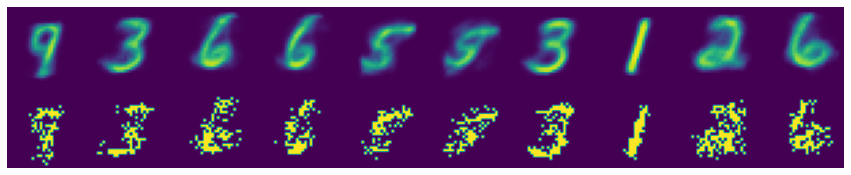

In [22]:
# function to reshape 784 array into a 28x28 image for plotting
def array_to_image(array):
  return np.reshape(np.array(array), [28, 28])

def concat_images(images, row, col, padding = 3):
  result = np.zeros((28*row+(row-1)*padding,28*col+(col-1)*padding))
  for i in range(row):
    for j in range(col):
      result[i*28+(i*padding):i*28+(i*padding)+28, j*28+(j*padding):j*28+(j*padding)+28] = images[i+j*row]
  return result

# Sample z from prior
z_mu = torch.FloatTensor([0]*latent_dimension).expand(10,-1)
z_sigma = torch.FloatTensor([1]*latent_dimension).expand(10,-1)
sampled_z = sample_diagonal_gaussian(z_mu, z_sigma)

# plot p(x|z)
ys = []
y = decoder(sampled_z)

# Sample x from p(x|z) 
x = sample_Bernoulli(y)
for i in range(10):
  ys.append(array_to_image(y[i,:].detach().numpy()))
  ys.append(array_to_image(x[i,:].detach().numpy()))

# Concatenate plots into a figure
concated_image = concat_images(ys, 2, 10)
fig = plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(concated_image)

### As Columns

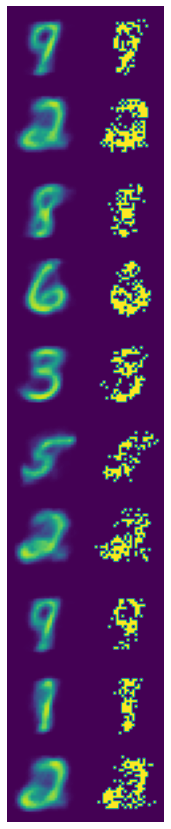

In [19]:
# function to reshape 784 array into a 28x28 image for plotting
def array_to_image(array):
  return np.reshape(np.array(array), [28, 28])

def concat_images(images, row, col, padding = 3):
  result = np.zeros((28*row+(row-1)*padding,28*col+(col-1)*padding))
  for i in range(row):
    for j in range(col):
      result[i*28+(i*padding):i*28+(i*padding)+28, j*28+(j*padding):j*28+(j*padding)+28] = images[i+j*row]
  return result

# Sample z from prior
z_mu = torch.FloatTensor([0]*latent_dimension).expand(10,-1)
z_sigma = torch.FloatTensor([1]*latent_dimension).expand(10,-1)
sampled_z = sample_diagonal_gaussian(z_mu, z_sigma)

# plot p(x|z)
ys = []
y = decoder(sampled_z)
for i in range(10):
  ys.append(array_to_image(y[i,:].detach().numpy()))

# Sample x from p(x|z) 
xs = []
x = sample_Bernoulli(y)
for i in range(10):
  xs.append(array_to_image(x[i,:].detach().numpy()))

# Concatenate plots into a figure
concated_image = concat_images(ys+xs, 10, 2)
fig = plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(concated_image)

## Quesion (3)-b : Latent Space 

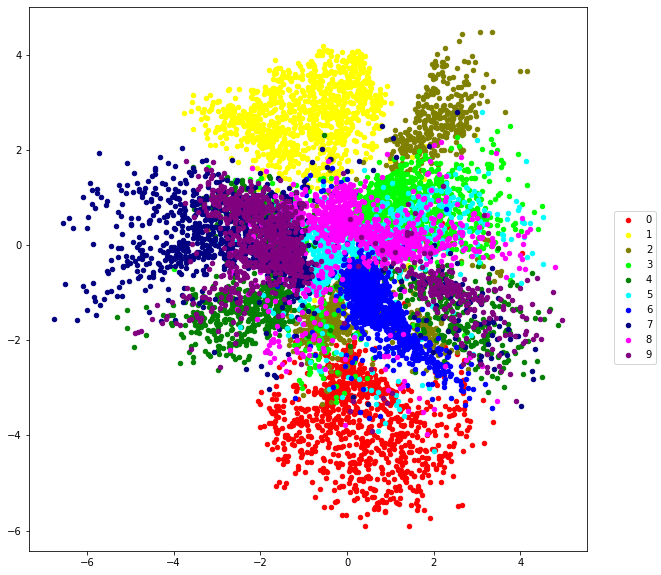

In [24]:
# Encode the training data
mu, sigma_square = encoder(train_images)

# Take the mean vector of each encoding
mean = mu.detach().numpy()

# Plot the mean and Colour each point depending on the class label
colours = ["Red", "Yellow", "Olive", "Lime", "Green", 
           "Aqua","Blue","Navy", "Fuchsia", "Purple"]
fig = plt.figure(figsize = (10,10))
for i in range(10):
  sample_index = np.nonzero(train_labels.numpy()[:,i])[0]
  cur_digit_means = mean[sample_index]
  plt.scatter(cur_digit_means[:,0], cur_digit_means[:,1],c=colours[i],  label='%d' % i , s=20)
  
fig.legend(loc=5)
plt.show()

## Question (3)-c :interpolate between the latent representations of two points.

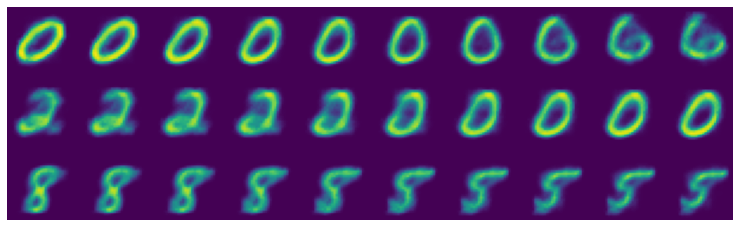

In [25]:
#in the prodiced plots, each row is the interpolations of a pair of xs, with alpha being 0, 0.1, ... , 1.0
# Function which gives linear interpolation z_α between za and zb
def interpolate_mu(mua, mub, alpha = 0.5):
  return alpha*mua + (1-alpha)*mub

# Sample 3 pairs of data with different classes
pairs = []
while len(pairs) < 3:
  i1 = int(np.random.rand() * 10000)
  i2 = int(np.random.rand() * 10000)
  if not train_labels[i1].equal(train_labels[i2]):
    pairs.append([train_images[i1],train_images[i2]])
    
# Encode the data in each pair, and take the mean vectors
pairs_mus = []
for p in pairs:
  mu1, sigma_square1 = encoder(p[0])
  mu2, sigma_square2 = encoder(p[1])
  pairs_mus.append([mu1,mu2])

# Linearly interpolate between these mean vectors
z_alphas = []
for alpha in np.arange(0,1,0.1):
  for p in pairs_mus:
    z_alphas.append(interpolate_mu(p[0],p[1],alpha))

# Along the interpolation, plot the distributions p(x|z_α)
plots = []
for z in z_alphas:
  y = decoder(z)
  plots.append(array_to_image(y.detach().numpy()))
  
# Concatenate these plots into one figure
final_plot = concat_images(plots, 3,10)
fig = plt.figure(figsize = (13,13))
plt.axis('off')
plt.imshow(final_plot)


# Question (4): Predicting the Bottom of Images given the Top

## Question (4): a

In [0]:
#set the random seeds for reproducebility
r_seed = 0
np.random.seed(r_seed)
torch.random.manual_seed(r_seed) 

# Function which returns only the top half of a 28x28 array
# This will be useful for plotting, as well as selecting correct bernoulli params
def top_half_array(array):
  return array[:,0:392] #since the input will be Batch_sizex784 array, return first half of each row

# log_p(x_top | z) (hint: select top half of 28x28 bernoulli param array)
def log_p_xtop_z(x,y):
  x = top_half_array(x.reshape(1,-1))
  y = top_half_array(y)
  return logpdf_bernoulli(x.expand_as(y), y)

# Combine likelihood with prior
def log_combine(x,z):
    return log_p_xtop_z(x_top, z) + log_p_z(z)


## Random Calculations and CODE FOR ISOCONTOR PLOT:

In [0]:
#set the random seeds for reproducebility
r_seed =0
np.random.seed(r_seed)
torch.random.manual_seed(r_seed) 

x = train_images[int(np.random.rand() * 10000),:]

mu, sigma_square = encoder(x)
delta_z = 0.01
steps = 50
grid = np.mgrid[mu[0].item()-steps*delta_z:mu[0].item()+(steps+0.5)*delta_z:delta_z, 
                mu[1].item()-steps*delta_z:mu[1].item()+(steps+0.5)*delta_z:delta_z, ]
z_points = grid.reshape(2,-1).T
z_tensor = torch.from_numpy(z_points).float()

def numerical_integration(evaluations, delta_z):
  return logsumexp(evaluations + 2*np.log(delta_z))

def logsumexp(nums):
  a = np.max(nums)
  return a + np.log(np.sum(np.exp(nums - a)))

#set the random seeds for reproducebility
r_seed =0
np.random.seed(r_seed)
torch.random.manual_seed(r_seed) 

x = train_images[int(np.random.rand() * 10000),:]

mu, sigma_square = encoder(x)
delta_z = 0.01
steps = 50
grid = np.mgrid[mu[0].item()-steps*delta_z:mu[0].item()+(steps+0.5)*delta_z:delta_z, 
                mu[1].item()-steps*delta_z:mu[1].item()+(steps+0.5)*delta_z:delta_z, ]
z_points = grid.reshape(2,-1).T
z_tensor = torch.from_numpy(z_points).float()

z_mu = torch.FloatTensor([0]*latent_dimension)
z_sigma = torch.FloatTensor([1]*latent_dimension)
log_p_z = logpdf_diagonal_gaussian(z_tensor, z_mu, z_sigma).numpy()

y = decoder(z_tensor)
log_p_xz = logpdf_bernoulli(x.expand_as(y), y).detach().numpy()
log_f_z = log_p_z + log_p_xz

log_p_x = numerical_integration(log_f_z, delta_z)

log_p_zx = log_f_z - log_p_x

log_q = logpdf_diagonal_gaussian(z_tensor, mu.expand_as(z_tensor), sigma_square.expand_as(z_tensor)).detach().numpy()

In [0]:
x = train_images[int(np.random.rand() * 10000),:]

mu, sigma_square = encoder(x)
delta_z = 0.01
steps = 50
grid = np.mgrid[mu[0].item()-steps*delta_z:mu[0].item()+(steps+0.5)*delta_z:delta_z, 
                mu[1].item()-steps*delta_z:mu[1].item()+(steps+0.5)*delta_z:delta_z, ]
z_points = grid.reshape(2,-1).T
z_tensor = torch.from_numpy(z_points).float()

z_mu = torch.FloatTensor([0]*latent_dimension)
z_sigma = torch.FloatTensor([1]*latent_dimension)
log_p_z = logpdf_diagonal_gaussian(z_tensor, z_mu, z_sigma).numpy()

y = decoder(z_tensor)
log_p_xz = log_p_xtop_z(x,y).detach().numpy()
log_f_z = log_p_z + log_p_xz

log_p_xtop = numerical_integration(log_f_z, delta_z)

log_p_zxtop = log_f_z - log_p_xtop

## question (4) : b

In [34]:
# Initialize parameters μ and logσ for variational distribution q(z)
train_mu = torch.tensor([0.0,0.0], requires_grad=True)
train_log_sigma_square = torch.randn(2,requires_grad=True)

# Define mean ELBO using log_p(z), log_p(x_top | z), and q(z|x_top)
def elbo_q(x_top, mu, logsigma, m):
    mu_batch, logsigma_batch = mu.repeat(m, 1), logsigma.repeat(m, 1)
    z = sample_z(mu_batch, logsigma_batch)
    return (log_p_xtop_z(x_top, z) + log_p_z(z) - log_q_zgivenx(z, mu_batch, logsigma_batch)).mean()


# ADAM to optimize
adam_optimizer = optim.Adam([train_mu] + [train_log_sigma_square],lr=1)

num_iters = 100
m = 100
for i in range(num_iters):
  adam_optimizer.zero_grad()
  train_sigma_square = torch.exp(train_log_sigma_square)
  sample_z = sample_diagonal_gaussian(train_mu.expand(m,-1),train_sigma_square.expand(m,-1))
  y = decoder(sample_z)
  y_top = top_half_array(y)
  x_top = top_half_array(x.reshape(1,-1)).expand_as(y_top)
  elbo = mc_elbo(sample_z, train_mu, train_sigma_square, x_top, y_top)
  total_loss = -elbo
  total_loss.backward()
  adam_optimizer.step()
  if i%1 == 0:
    print("Test loss at epoch: " + str(i) + ", Negative ELBO:" + str(-elbo.item()))
    
train_sigma_square = torch.exp(train_log_sigma_square)


Test loss at epoch: 0, Negative ELBO:97.6462631225586
Test loss at epoch: 1, Negative ELBO:79.78648376464844
Test loss at epoch: 2, Negative ELBO:72.00028991699219
Test loss at epoch: 3, Negative ELBO:65.45349884033203
Test loss at epoch: 4, Negative ELBO:63.05620193481445
Test loss at epoch: 5, Negative ELBO:62.20832443237305
Test loss at epoch: 6, Negative ELBO:62.641056060791016
Test loss at epoch: 7, Negative ELBO:60.86069869995117
Test loss at epoch: 8, Negative ELBO:62.27872085571289
Test loss at epoch: 9, Negative ELBO:62.24235916137695
Test loss at epoch: 10, Negative ELBO:61.49726867675781
Test loss at epoch: 11, Negative ELBO:62.91044616699219
Test loss at epoch: 12, Negative ELBO:62.47650909423828
Test loss at epoch: 13, Negative ELBO:62.020782470703125
Test loss at epoch: 14, Negative ELBO:63.081748962402344
Test loss at epoch: 15, Negative ELBO:62.693603515625
Test loss at epoch: 16, Negative ELBO:62.26949691772461
Test loss at epoch: 17, Negative ELBO:62.608646392822266
T

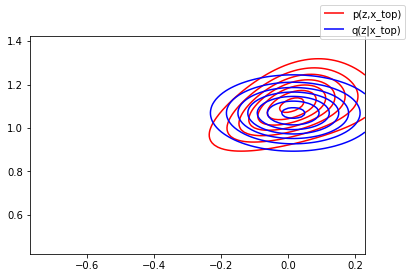

In [35]:
fig = plt.figure()
c1 = plt.contour(plot_x, plot_y, p_zxtop, colors = 'red')
h1,_ = c1.legend_elements()

log_q = logpdf_diagonal_gaussian(z_tensor, train_mu.expand_as(z_tensor), train_sigma_square.expand_as(z_tensor)).detach().numpy()
q_zx = np.exp(log_q).reshape(2*steps+1, 2*steps + 1)
c2 = plt.contour(plot_x, plot_y, q_zx, colors = 'blue')
h2,_ = c2.legend_elements()

fig.legend([h1[0], h2[0]], ["p(z,x_top)", "q(z|x_top)"])
plt.show()

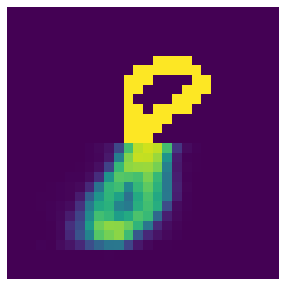

In [36]:
# Sample z ~ q(z)
sample_z = sample_diagonal_gaussian(train_mu,train_sigma_square)

# Use generative model p(x|z) to produce distribution over x
y = decoder(sample_z)


# Extract the bottom half of this generative distribution: p(x_bot| z)
y_bot = y[392:784].detach().numpy()

# Concatenate the x_top and p(x_bot | z) and plot.
x_top= top_half_array(x.reshape(1,-1)).numpy().reshape(392)
image = np.concatenate((x_top, y_bot)).reshape(28,28)
fig = plt.figure(figsize = (5,5))
plt.axis('off')
plt.imshow(image)

### Plot the original whole image beside it for comparison.

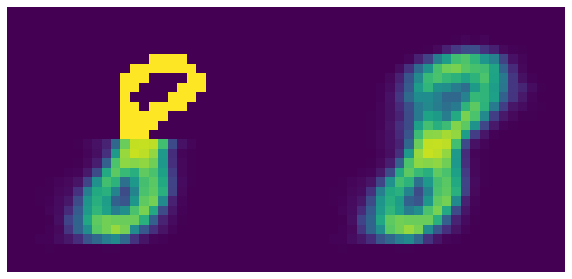

In [37]:
sample_z = sample_diagonal_gaussian(train_mu,train_sigma_square)
y = decoder(sample_z)
y_bot = y[0:784].detach().numpy()
y_half = y[392:784].detach().numpy()

x_top= top_half_array(x.reshape(1,-1)).numpy().reshape(392)
image_mix = np.concatenate((x_top, y_half)).reshape(28,28)
image = y_bot.reshape(28,28)

images = []
images.append(image_mix)
images.append(image)

image = concat_images(images, 1, 2)
fig = plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(image)

# Question (4)- c

a- 

b- 

c- False, the increase in the ELBO means reducing the KL distance or increas in log p(x)

d- Flase, the probaility can not ne negative

e- True, yes the probability might can exceed 1. For example, a nromal dsitribution with mean of 0 and variance of 0.01, p(x=0) = 3.94, as shown in assignmnet A0.